# 2x2 Puzzle Solver Batch Test (v2)

This notebook uses **Pairwise Neighbor Accuracy** with proper ground-truth labeling.

- Piece IDs are arbitrary (no semantic meaning)
- Ground truth is derived by matching shuffled pieces to the correct image
- Accuracy measures relative adjacency, not absolute position

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, Tuple, List
from solvers.solver_2x2 import solve_2x2
from accuracy_utils import (
    compute_pairwise_neighbor_accuracy,
    load_puzzle_with_ground_truth,
    arrangement_to_grid,
    reconstruct_image
)

%matplotlib inline

## Configuration

In [2]:
PUZZLE_DIR = "./Gravity Falls/puzzle_2x2"
CORRECT_DIR = "./Gravity Falls/correct"
NUM_IMAGES = 110
GRID_SIZE = 2

## Run Batch Test

In [3]:
puzzle_path = Path(PUZZLE_DIR)
correct_path = Path(CORRECT_DIR)

puzzle_files = sorted(puzzle_path.glob("*.jpg"), key=lambda p: int(p.stem))[:NUM_IMAGES]
print(f"Found {len(puzzle_files)} puzzle images")

Found 110 puzzle images


In [4]:
results = []

for i, puzzle_file in enumerate(puzzle_files):
    # Find corresponding correct image
    correct_file = correct_path / f"{puzzle_file.stem}.png"
    if not correct_file.exists():
        correct_file = correct_path / f"{puzzle_file.stem}.jpg"
    
    if not correct_file.exists():
        print(f"[{i+1}] {puzzle_file.name}: SKIP (no correct image)")
        continue
    
    try:
        # Load with ground truth using shared utility
        artifacts, ground_truth_labels = load_puzzle_with_ground_truth(
            str(puzzle_file), str(correct_file), GRID_SIZE
        )
        
        # Solve
        arrangement, solver_score = solve_2x2(artifacts, verbose=False)
        
        # Compute accuracy
        reconstructed_grid = arrangement_to_grid(arrangement, GRID_SIZE)
        accuracy = compute_pairwise_neighbor_accuracy(reconstructed_grid, ground_truth_labels)
        
        status = "✓" if accuracy == 1.0 else f"{accuracy:.0%}"
        print(f"[{i+1}] {puzzle_file.name}: {status}")
        
        results.append({
            'image': puzzle_file.name,
            'arrangement': arrangement,
            'solver_score': solver_score,
            'neighbor_accuracy': accuracy,
            'ground_truth_labels': ground_truth_labels,
            'artifacts': artifacts
        })
        
    except Exception as e:
        print(f"[{i+1}] {puzzle_file.name}: ERROR - {e}")
        results.append({
            'image': puzzle_file.name,
            'neighbor_accuracy': 0.0,
            'error': str(e)
        })

[1] 0.jpg: ✓
[2] 1.jpg: ✓
[3] 2.jpg: ✓
[4] 3.jpg: ✓
[5] 4.jpg: ✓
[6] 5.jpg: ✓
[7] 6.jpg: ✓
[8] 7.jpg: ✓
[9] 8.jpg: ✓
[10] 9.jpg: ✓
[11] 10.jpg: ✓
[12] 11.jpg: ✓
[13] 12.jpg: ✓
[14] 13.jpg: ✓
[15] 14.jpg: ✓
[16] 15.jpg: ✓
[17] 16.jpg: ✓
[18] 17.jpg: ✓
[19] 18.jpg: ✓
[20] 19.jpg: ✓
[21] 20.jpg: ✓
[22] 21.jpg: ✓
[23] 22.jpg: ✓
[24] 23.jpg: ✓
[25] 24.jpg: ✓
[26] 25.jpg: ✓
[27] 26.jpg: ✓
[28] 27.jpg: ✓
[29] 28.jpg: ✓
[30] 29.jpg: ✓
[31] 30.jpg: ✓
[32] 31.jpg: ✓
[33] 32.jpg: ✓
[34] 33.jpg: ✓
[35] 34.jpg: ✓
[36] 35.jpg: ✓
[37] 36.jpg: ✓
[38] 37.jpg: ✓
[39] 38.jpg: ✓
[40] 39.jpg: ✓
[41] 40.jpg: ✓
[42] 41.jpg: ✓
[43] 42.jpg: ✓
[44] 43.jpg: ✓
[45] 44.jpg: ✓
[46] 45.jpg: ✓
[47] 46.jpg: ✓
[48] 47.jpg: ✓
[49] 48.jpg: ✓
[50] 49.jpg: ✓
[51] 50.jpg: ✓
[52] 51.jpg: ✓
[53] 52.jpg: ✓
[54] 53.jpg: ✓
[55] 54.jpg: 25%
[56] 55.jpg: ✓
[57] 56.jpg: ✓
[58] 57.jpg: ✓
[59] 58.jpg: ✓
[60] 59.jpg: ✓
[61] 60.jpg: ✓
[62] 61.jpg: ✓
[63] 62.jpg: ✓
[64] 63.jpg: ✓
[65] 64.jpg: ✓
[66] 65.jpg: ✓
[67] 66.jpg: ✓
[68] 67.jpg:

## Summary

In [5]:
valid_results = [r for r in results if 'error' not in r]
accuracies = [r['neighbor_accuracy'] for r in valid_results]

perfect_count = sum(1 for a in accuracies if a == 1.0)
mean_accuracy = np.mean(accuracies) if accuracies else 0.0

print(f"Total tested: {len(valid_results)}")
print(f"Perfect: {perfect_count}/{len(valid_results)} ({100*perfect_count/len(valid_results):.1f}%)")
print(f"Mean pairwise neighbor accuracy: {mean_accuracy:.2%}")

Total tested: 110
Perfect: 107/110 (97.3%)
Mean pairwise neighbor accuracy: 98.41%


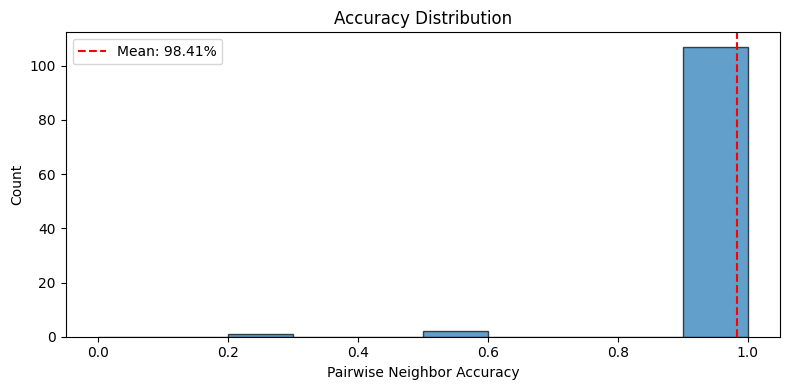

In [6]:
# Accuracy distribution
plt.figure(figsize=(8, 4))
plt.hist(accuracies, bins=10, range=(0, 1), edgecolor='black', alpha=0.7)
plt.xlabel('Pairwise Neighbor Accuracy')
plt.ylabel('Count')
plt.title('Accuracy Distribution')
plt.axvline(mean_accuracy, color='red', linestyle='--', label=f'Mean: {mean_accuracy:.2%}')
plt.legend()
plt.tight_layout()
plt.show()

## Visualize Results

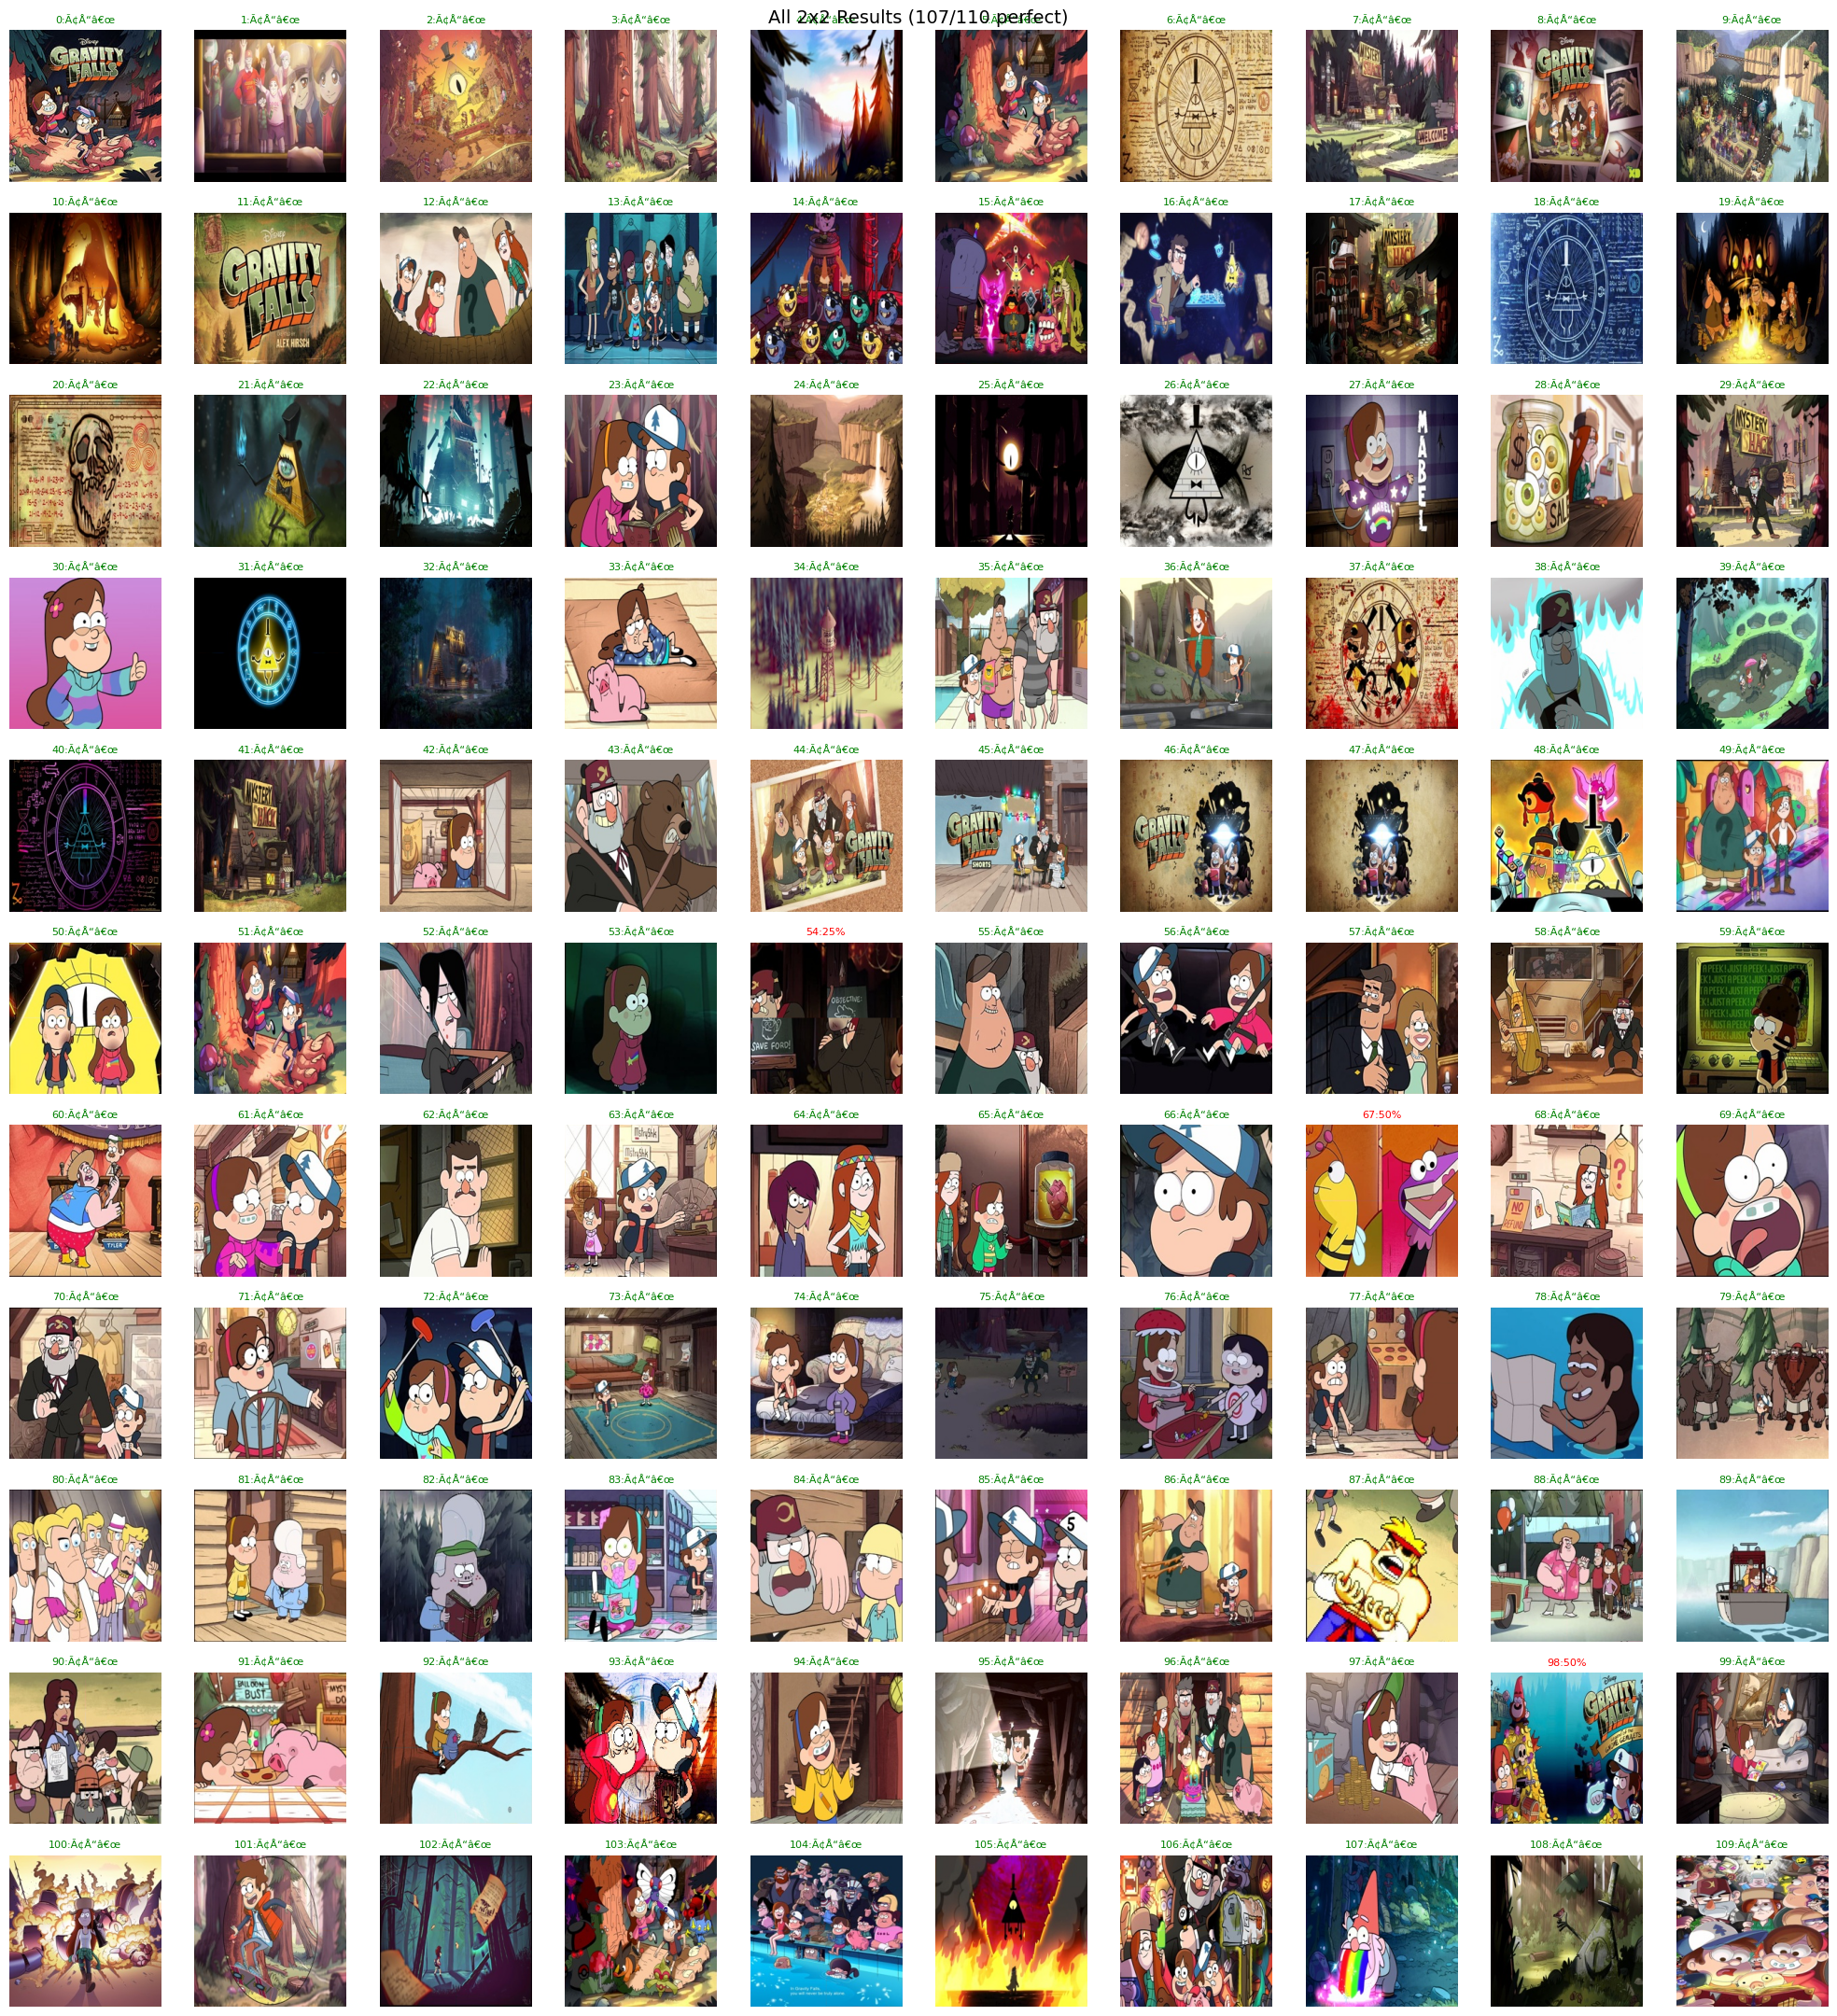

In [7]:
# Show ALL results in a grid
import math

n_total = len(valid_results)
n_cols = 10  # 10 images per row
n_rows = math.ceil(n_total / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes.flatten()

for i, r in enumerate(valid_results):
    # Reconstructed
    solved_img = reconstruct_image(r['artifacts'], r['arrangement'], GRID_SIZE)
    solved_rgb = cv2.cvtColor(solved_img, cv2.COLOR_BGR2RGB)
    
    ax = axes[i]
    ax.imshow(solved_rgb)
    status = "Ã¢Å“â€œ" if r['neighbor_accuracy'] == 1.0 else f"{r['neighbor_accuracy']:.0%}"
    color = 'green' if r['neighbor_accuracy'] == 1.0 else 'red'
    ax.set_title(f"{r['image'].replace('.jpg','')}:{status}", fontsize=8, color=color)
    ax.axis('off')

# Hide unused axes
for j in range(n_total, len(axes)):
    axes[j].axis('off')
    axes[j].set_visible(False)

plt.suptitle(f'All 2x2 Results ({perfect_count}/{n_total} perfect)', fontsize=14)
plt.tight_layout()
plt.show()

## Imperfect Solutions

In [8]:
imperfect = [r for r in valid_results if r['neighbor_accuracy'] < 1.0]

if imperfect:
    print(f"Imperfect solutions: {len(imperfect)}")
    for r in imperfect:
        print(f"  {r['image']}: {r['arrangement']} -> {r['neighbor_accuracy']:.0%}")
else:
    print("All solutions are perfect!")

Imperfect solutions: 3
  54.jpg: [1, 3, 2, 0] -> 25%
  67.jpg: [1, 0, 2, 3] -> 50%
  98.jpg: [0, 3, 1, 2] -> 50%
